<div style="float:left">
    <h1 style="width:600px">CASA Practical 4 Part 2: Neural networks using Keras and Yolo</h1>
</div>
<div style="float:right"><img width="100" src="https://github.com/jreades/i2p/raw/master/img/casa_logo.jpg" /></div>

In this practical, we will first use [Keras](https://www.tensorflow.org/guide/keras/overview) to:

1. Load a prebuilt dataset.
1. Build a neural network machine learning model that classifies images.
2. Train this neural network.
3. Evaluate the accuracy of the model.

The second half of this workshop extends these principles to conduct object detection in satellite imagery. 

As installing and configuring tensorflow on a local computer is not an easy job, I recommend using Google Colab for this practical. Click [here]() to run this practical on Google Colab, which requires a Google account.

If you are following along in your own development environment, rather than Colab, see the [install guide](https://www.tensorflow.org/install) for setting up TensorFlow for development.

Note: Make sure you have upgraded to the latest `pip` to install the TensorFlow 2 package if you are using your own development environment. See the [install guide](https://www.tensorflow.org/install) for details.

## Set up TensorFlow

Import TensorFlow into your program to get started:

In [ ]:
pip install -I --no-cache-dir tensorflow

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

#print("TensorFlow version:", tf.__version__)

## Load a dataset

Load and prepare the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). Convert the sample data from integers to floating-point numbers:

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

11501568/11490434 [==============================] - 1s 0us/step


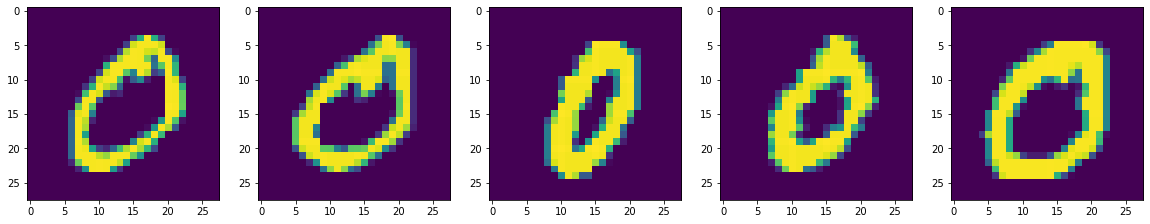

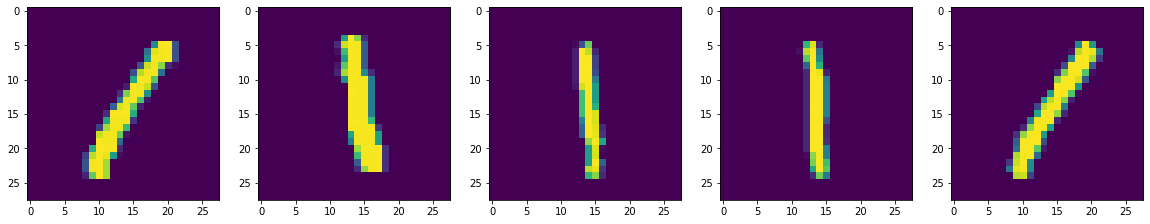

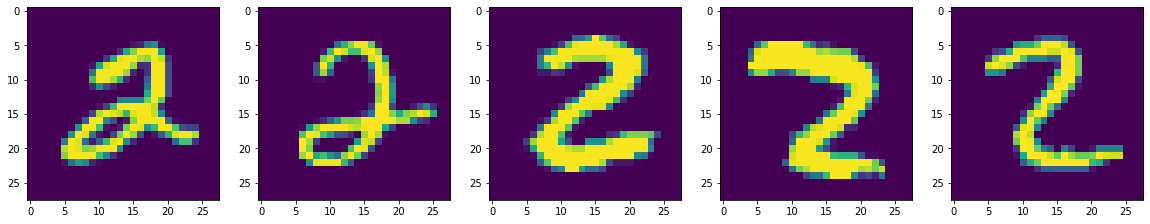

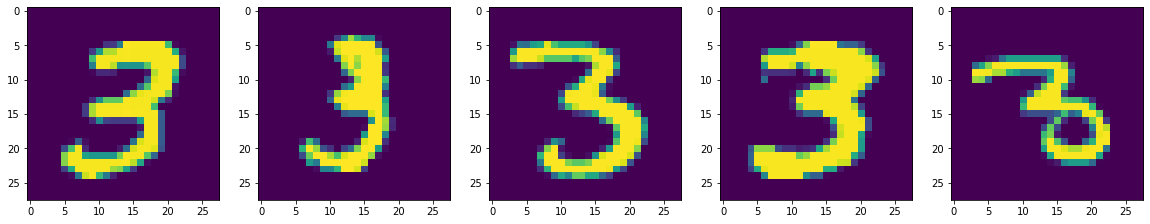

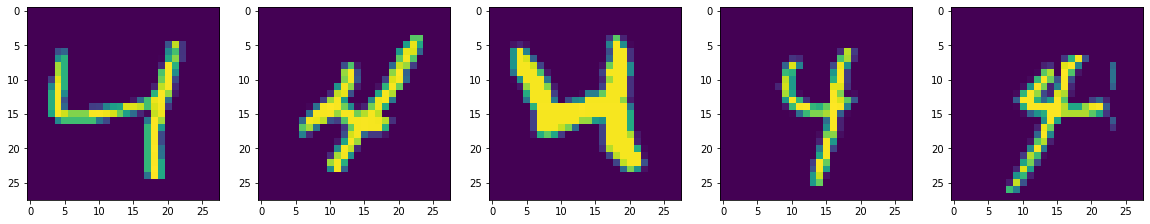

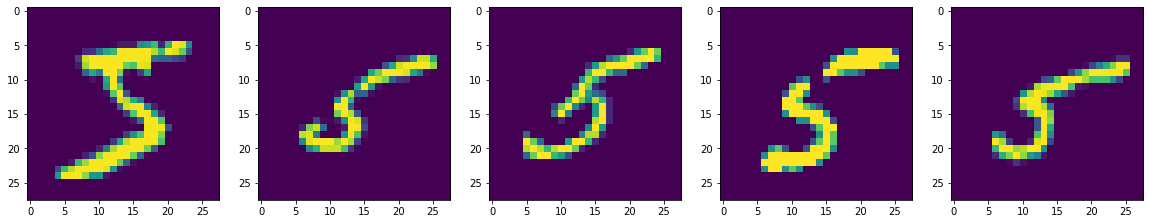

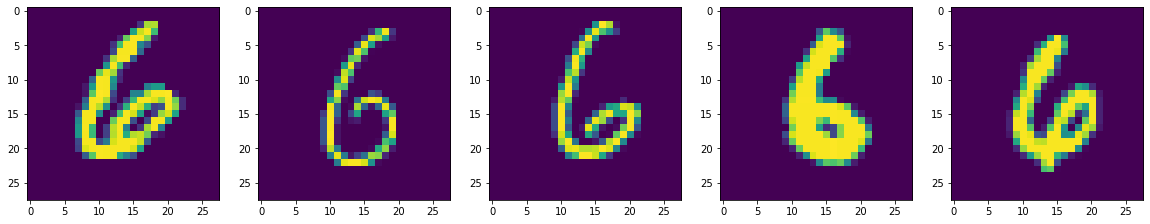

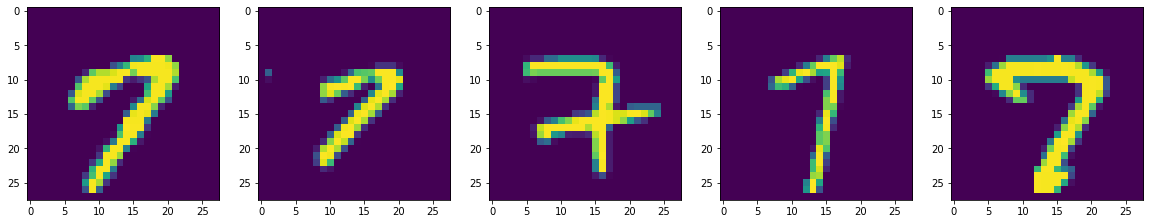

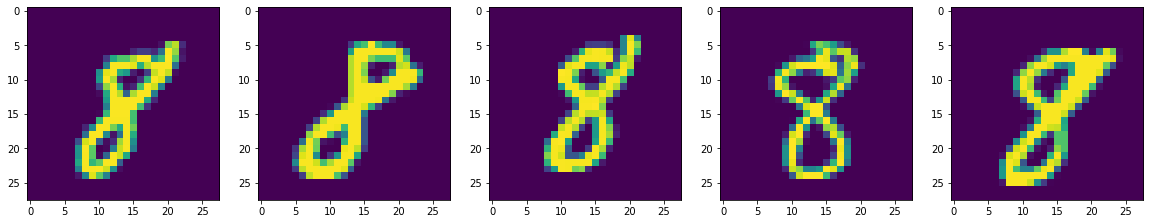

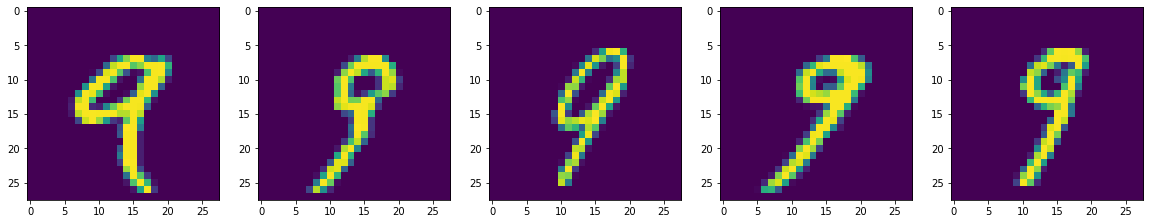

In [3]:

def plot_num(number):

  item_index = np.where(y_train[:1000]==number)
  subset=x_train[item_index]
  
  egs=5
  fig, axs = plt.subplots(1,egs, figsize=(20,10))

  for i in range(0,egs):
    axs[i].imshow(subset[i])


for x in range(0,10):
  plot_num(x)

## Build a machine learning model

Build a `tf.keras.Sequential` model by stacking layers.

In [4]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

For each example, the model returns a vector of [logits](https://developers.google.com/machine-learning/glossary#logits) or [log-odds](https://developers.google.com/machine-learning/glossary#log-odds) scores, one for each class.

In [5]:
predictions = model(x_train[:1]).numpy()
predictions

array([[-0.33507612, -0.8252177 ,  0.26956892,  0.10911827, -0.3388669 ,
        -0.08767619,  0.3187399 ,  0.02007107,  0.36295524,  0.57399803]],
      dtype=float32)

The `tf.nn.softmax` function converts these logits to *probabilities* for each class: 

In [6]:
tf.nn.softmax(predictions).numpy()

array([[0.06613602, 0.04051094, 0.12106875, 0.10312151, 0.06588579,
        0.08469982, 0.1271706 , 0.0943358 , 0.13291967, 0.16415116]],
      dtype=float32)

Note: It is possible to bake the `tf.nn.softmax` function into the activation function for the last layer of the network. While this can make the model output more directly interpretable, this approach is discouraged as it's impossible to provide an exact and numerically stable loss calculation for all models when using a softmax output. 

Define a loss function for training using `losses.SparseCategoricalCrossentropy`, which takes a vector of logits and a `True` index and returns a scalar loss for each example.

In [7]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

This loss is equal to the negative log probability of the true class: The loss is zero if the model is sure of the correct class.

This untrained model gives probabilities close to random (1/10 for each class), so the initial loss should be close to `-tf.math.log(1/10) ~= 2.3`.

In [10]:
loss_fn(y_train[:1], predictions).numpy()

2.4686418

Before you start training, configure and compile the model using Keras `Model.compile`. Set the [`optimizer`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) class to `adam`, set the `loss` to the `loss_fn` function you defined earlier, and specify a metric to be evaluated for the model by setting the `metrics` parameter to `accuracy`.

In [11]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

## Train and evaluate your model

Use the `Model.fit` method to adjust your model parameters and minimize the loss: 

In [12]:
model.fit(x_train, y_train, epochs=10)

2023-02-03 11:56:34.218031: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10
1875/1875 [==============================] - 1s 627us/step - loss: 0.2997 - accuracy: 0.9127
Epoch 2/10
1875/1875 [==============================] - 1s 616us/step - loss: 0.1437 - accuracy: 0.9573
Epoch 3/10
1875/1875 [==============================] - 1s 624us/step - loss: 0.1079 - accuracy: 0.9681
Epoch 4/10
1875/1875 [==============================] - 1s 615us/step - loss: 0.0890 - accuracy: 0.9720
Epoch 5/10
1875/1875 [==============================] - 1s 608us/step - loss: 0.0745 - accuracy: 0.9760
Epoch 6/10
1875/1875 [==============================] - 1s 623us/step - loss: 0.0657 - accuracy: 0.9792
Epoch 7/10
1875/1875 [==============================] - 1s 613us/step - loss: 0.0577 - accuracy: 0.9813
Epoch 8/10
1875/1875 [==============================] - 1s 598us/step - loss: 0.0538 - accuracy: 0.9825
Epoch 9/10
1875/1875 [==============================] - 1s 589us/step - loss: 0.0471 - accuracy: 0.9844
Epoch 10/10
1875/1875 [==============================] - 1s 684u

The `Model.evaluate` method checks the models performance, usually on a "[Validation-set](https://developers.google.com/machine-learning/glossary#validation-set)" or "[Test-set](https://developers.google.com/machine-learning/glossary#test-set)".

In [13]:
model.evaluate(x_test,  y_test, verbose=2)

313/313 - 0s - loss: 0.0668 - accuracy: 0.9811 - 191ms/epoch - 610us/step


[0.06678187102079391, 0.9811000227928162]

The image classifier is now trained to ~98% accuracy on this dataset. To learn more, read the [TensorFlow tutorials](https://www.tensorflow.org/tutorials/).

If you want your model to return a probability, you can wrap the trained model, and attach the softmax to it:

In [14]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

9


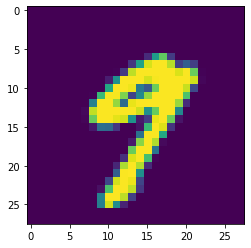

In [15]:
#probability_model(x_test[:1])
predictions=probability_model.predict(x_test)

index=20

print(np.argmax(predictions[index]))
plt.imshow(x_test[index])

## Conclusion

Congratulations! You have trained a machine learning model using a prebuilt dataset using the [Keras](https://www.tensorflow.org/guide/keras/overview) API.

For more examples of using Keras, check out the [tutorials](https://www.tensorflow.org/tutorials/keras/). To learn more about building models with Keras, read the [guides](https://www.tensorflow.org/guide/keras). If you want learn more about loading and preparing data, see the tutorials on [image data loading](https://www.tensorflow.org/tutorials/load_data/images) or [CSV data loading](https://www.tensorflow.org/tutorials/load_data/csv).


# YOLOv5 for Object Detection in Satellite Imagery

Having explored some of the basic principles of deep learning, we're now ready to apply this to a more explicitly spatial use case: object detection in satellite imagery. Read the [following guide](https://oballinger.github.io/GEE_OSINT/object_detection.html), and then complete the rest of this workbook. 

In [1]:
!git clone https://github.com/oballinger/yolov5_RS  # clone repo
#%cd yolov5_RS
%pip install -qr yolov5_RS/requirements.txt # install dependencies
%pip install -q roboflow

import torch
import os
from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

fatal: destination path 'yolov5_RS' already exists and is not an empty directory.
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
You should consider upgrading via the '/Users/ollieballinger/miniconda3/envs/min/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/ollieballinger/miniconda3/envs/min/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Setup complete. Using torch 1.13.1 (CPU)


In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="<YOUR API KEY>")
project = rf.workspace('ibl-huczk').project("ships-2fvbx")
dataset = project.version("1").download("yolov5")

In [ ]:
!python train.py --data {dataset.location}/data.yaml --batch 32 --cache

In [9]:
img='boneyard.jpg'
!python yolov5_RS/detect.py --weights yolov5_RS/weights/general.pt --img 2000 --conf 0.4 --source {img} --line-thickness 2 --exist-ok #--hide-labels --exist-ok

detect: weights=['yolov5_RS/weights/general.pt'], source=boneyard.jpg, data=yolov5_RS/data/coco128.yaml, imgsz=[2000, 2000], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5_RS/runs/detect, name=exp, exist_ok=True, line_thickness=2, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 062781b Python-3.10.2 torch-1.13.1 CPU

Fusing layers... 
YOLOv5s summary: 232 layers, 7286973 parameters, 0 gradients
WARNING ⚠️ --img-size [2000, 2000] must be multiple of max stride 32, updating to [2016, 2016]
image 1/1 /Users/ollieballinger/Downloads/boneyard.jpg: 1376x2016 166 planes, 7 helicopters, 773.7ms
Speed: 7.1ms pre-process, 773.7ms inference, 3.4ms NMS per image at shape (1, 3, 2016, 2016)
Results saved to yolov5_RS/runs/detect/exp


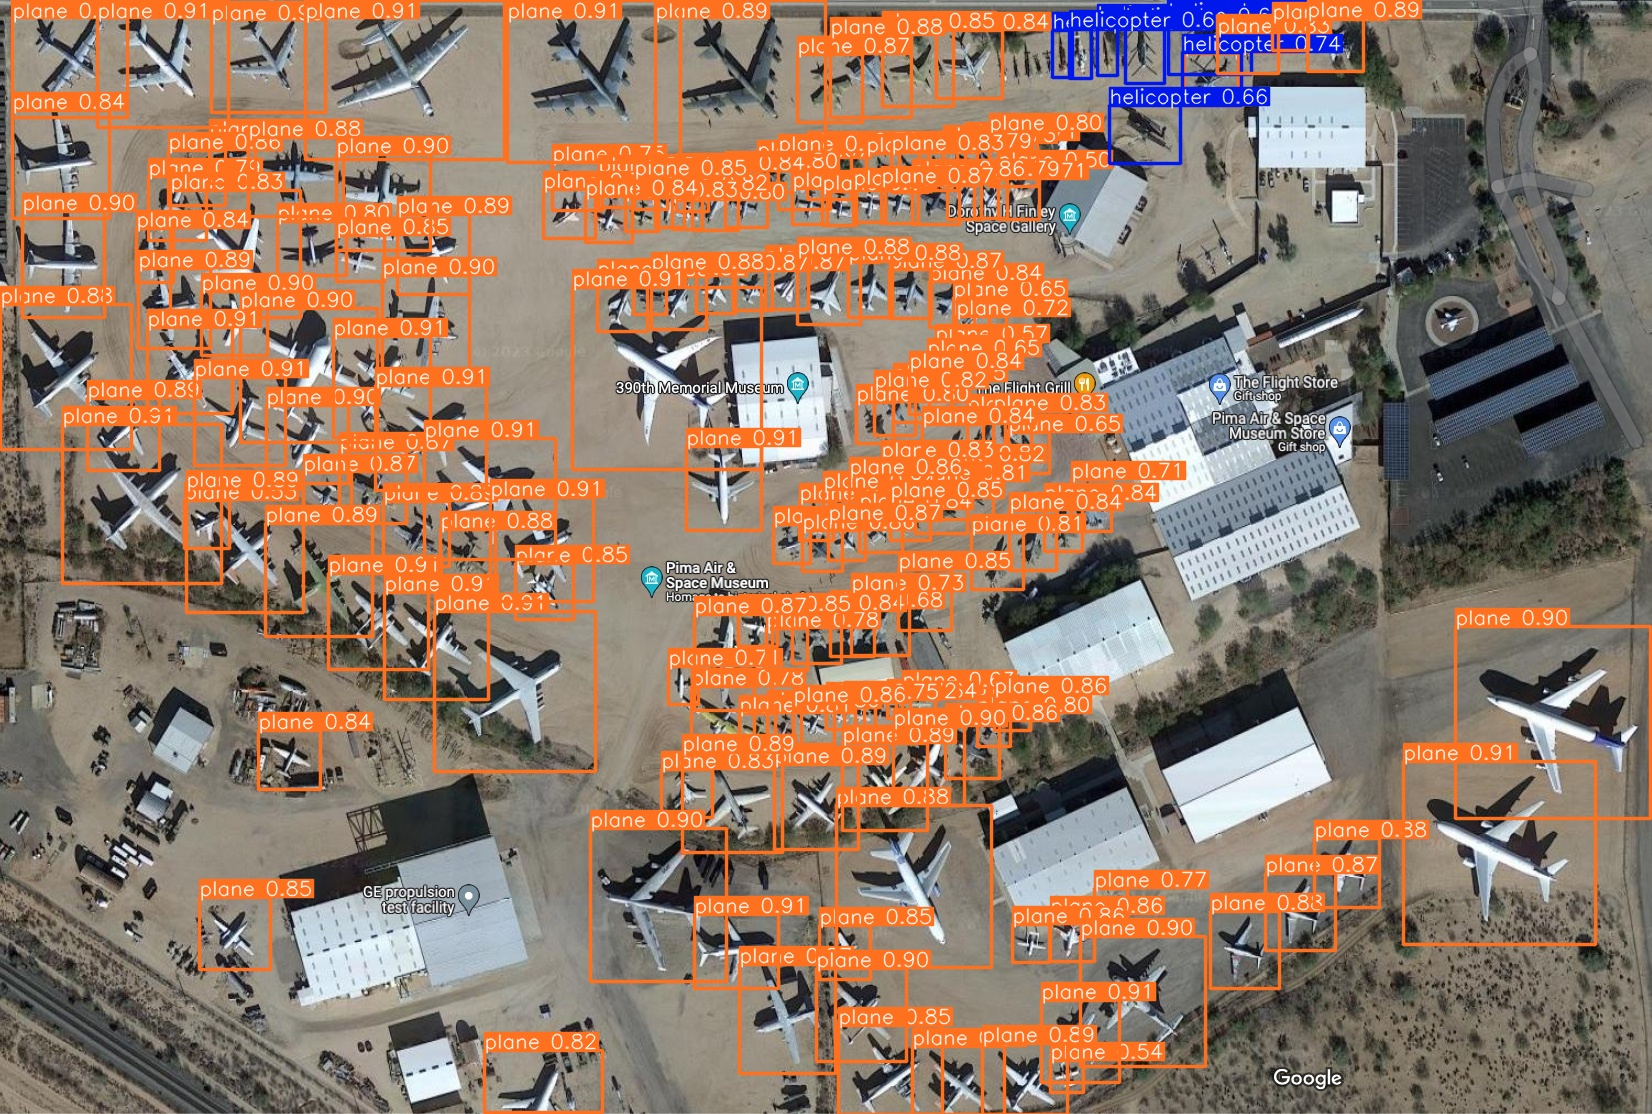

In [10]:
out_dir='yolov5_RS/runs/detect/exp'
Image(filename=os.path.join(out_dir,img))